In [1]:
try:
    %tensorflow_version 2.x
except:
    pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Unzip dataset

In [5]:
import zipfile

zip_path = '/content/sssss.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Import Library

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("\u2024 Using TensorFlow Version:", tf.__version__)
print(
    "\u2024 GPU Device Found."
    if tf.test.is_gpu_available()
    else "\u2024 GPU Device Not Found. Running on CPU"
)

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10

․ Using TensorFlow Version: 2.15.0
․ GPU Device Found.


# Data Processing

In [64]:
fpath = "/content/sssss/train"
random_seed = 42

In [65]:
img_size = 224
batch_size =32
train = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 942 files belonging to 8 classes.
Using 754 files for training.


In [66]:
val = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 942 files belonging to 8 classes.
Using 188 files for validation.


In [67]:
class_names = train.class_names

In [68]:
print(class_names)

['Early_blight', 'Healthy', 'Late_blight', 'Leaf Miner', 'Magnesium Deficiency', 'Nitrogen Deficiency', 'Pottassium Deficiency', 'Spotted Wilt Virus']


In [71]:
names = []
for name in class_names:
    if "-" in name:
        names.append(name.split("-")[1])
    else:
        names.append(name)

print(names[:8])


['Early_blight', 'Healthy', 'Late_blight', 'Leaf Miner', 'Magnesium Deficiency', 'Nitrogen Deficiency', 'Pottassium Deficiency', 'Spotted Wilt Virus']


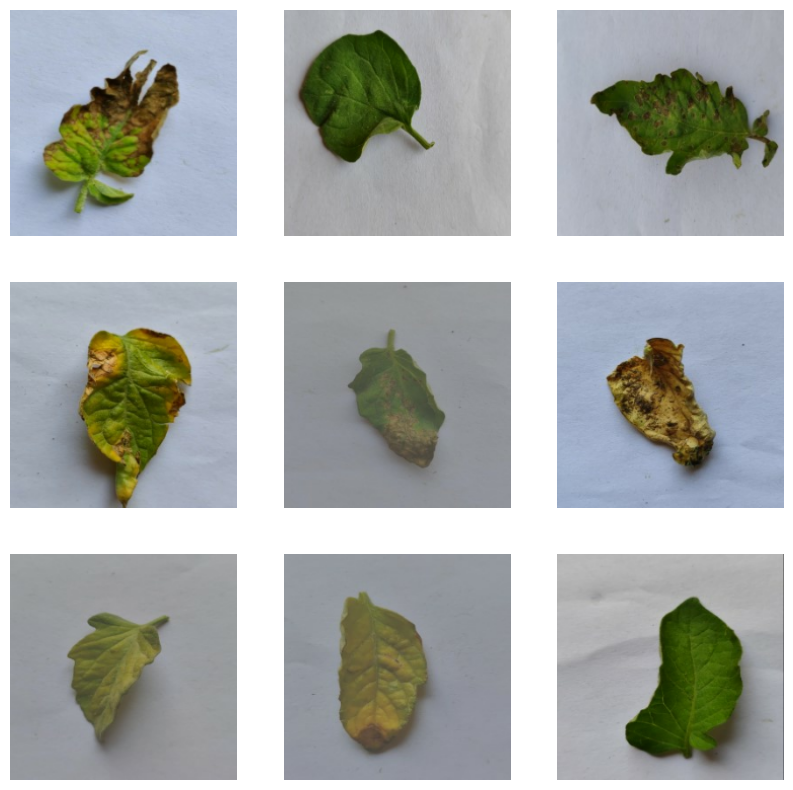

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Setup Configuration Transfer Learning

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    hub.KerasLayer('https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'),
    tf.keras.layers.Dense(8, activation="softmax")  # Adjust the number of units to match your dataset
])


In [82]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

In [83]:
model.build((img_size, img_size, 3))

In [84]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dense_2 (Dense)             (None, 8)                 8016      
                                                                 
Total params: 25623865 (97.75 MB)
Trainable params: 8016 (31.31 KB)
Non-trainable params: 25615849 (97.72 MB)
_________________________________________________________________


In [85]:
model_name = "macro_project.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                                monitor="val_loss",
                                                mode="min",
                                                save_best_only=True,
                                                verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                                                 verbose=1, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=0.0001)


# Training Model

In [86]:
history = model.fit(train, epochs=30, validation_data=val, callbacks=[checkpoint, reduce_lr])


Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 2.2635 - accuracy: 0.2838
Epoch 1: val_loss improved from inf to 1.71471, saving model to macro_project.h5
24/24 [==============================] - 25s 719ms/step - loss: 2.2635 - accuracy: 0.2838 - val_loss: 1.7147 - val_accuracy: 0.4309 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 1.2832 - accuracy: 0.5013
Epoch 2: val_loss improved from 1.71471 to 1.27108, saving model to macro_project.h5
24/24 [==============================] - 10s 395ms/step - loss: 1.2832 - accuracy: 0.5013 - val_loss: 1.2711 - val_accuracy: 0.5532 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.9965 - accuracy: 0.6233
Epoch 3: val_loss improved from 1.27108 to 1.15097, saving model to macro_project.h5
24/24 [==============================] - 9s 393ms/step - loss: 0.9965 - accuracy: 0.6233 - val_loss: 1.1510 - val_accuracy: 0.5851 - lr: 0.0010
Epoch 4/30
24/24 [===============

# Visualization

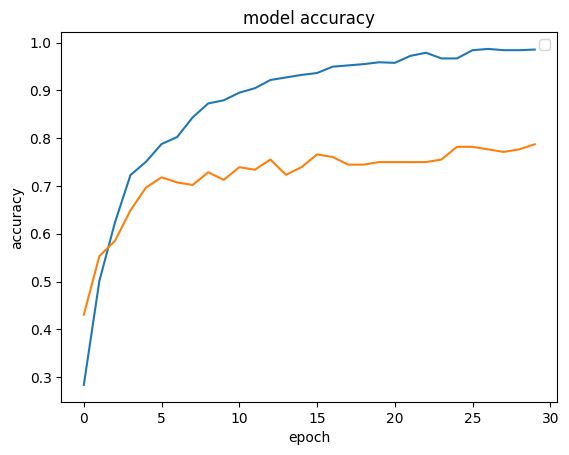

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

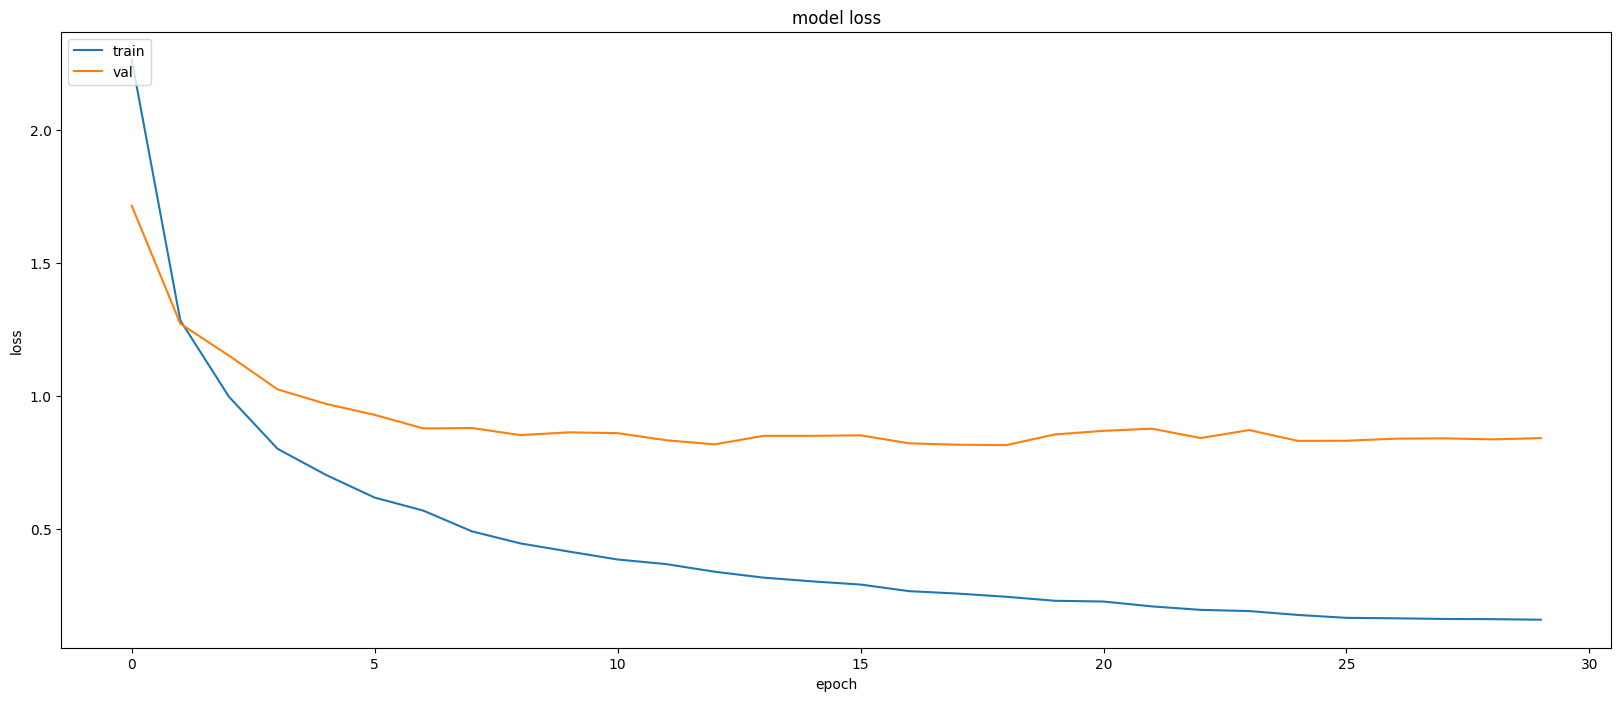

In [87]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [89]:
loss, accuracy = model.evaluate(val)


6/6 [==============================] - 1s 96ms/step - loss: 0.8406 - accuracy: 0.7872


In [90]:
print(f"Accuracy is: {round(accuracy*100,2)}%")


Accuracy is: 78.72%
